In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import pearsonr, pointbiserialr
import statsmodels.api as sm

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [2]:
df = pd.read_csv("heart.csv")
X = df.drop("target", axis=1)
y = df["target"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# **Feature Selection**

In [3]:
#P-value (OLS)
X_ols = sm.add_constant(X_scaled)
model = sm.OLS(y, X_ols).fit()
p_values = model.pvalues[1:]
pvalue_selected = p_values[p_values < 0.05].index.tolist()

#LASSO
lasso = LassoCV(cv=5).fit(X_scaled, y)
lasso_coeff = pd.Series(lasso.coef_, index=X.columns)
lasso_selected = lasso_coeff[lasso_coeff != 0].index.tolist()

#ANOVA
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_scaled, y)
anova_scores = pd.Series(selector.scores_, index=X.columns)
anova_selected = anova_scores.sort_values(ascending=False).head(5).index.tolist()

#Pearson Correlation
corr_with_target = {}
for col in X.columns:
    corr, _ = pearsonr(X[col], y)
    corr_with_target[col] = abs(corr)
corr_selected = sorted(corr_with_target, key=corr_with_target.get, reverse=True)[:5]

# Point-Biserial
pbs_corr = {}
for col in X.columns:
    corr, _ = pointbiserialr(X[col], y)
    pbs_corr[col] = abs(corr)
pbs_selected = sorted(pbs_corr, key=pbs_corr.get, reverse=True)[:5]


Feature Selection Summary:
           P-Value  LASSO  ANOVA  Pearson  PointBiserial
age         False   True  False    False          False
sex          True   True  False    False          False
cp           True   True   True     True           True
trestbps    False   True  False    False          False
chol        False   True  False    False          False
fbs         False   True  False    False          False
restecg     False   True  False    False          False
thalach      True   True   True     True           True
exang        True   True   True     True           True
oldpeak      True   True   True     True           True
slope       False   True  False    False          False
ca           True   True   True     True           True
thal         True   True  False    False          False


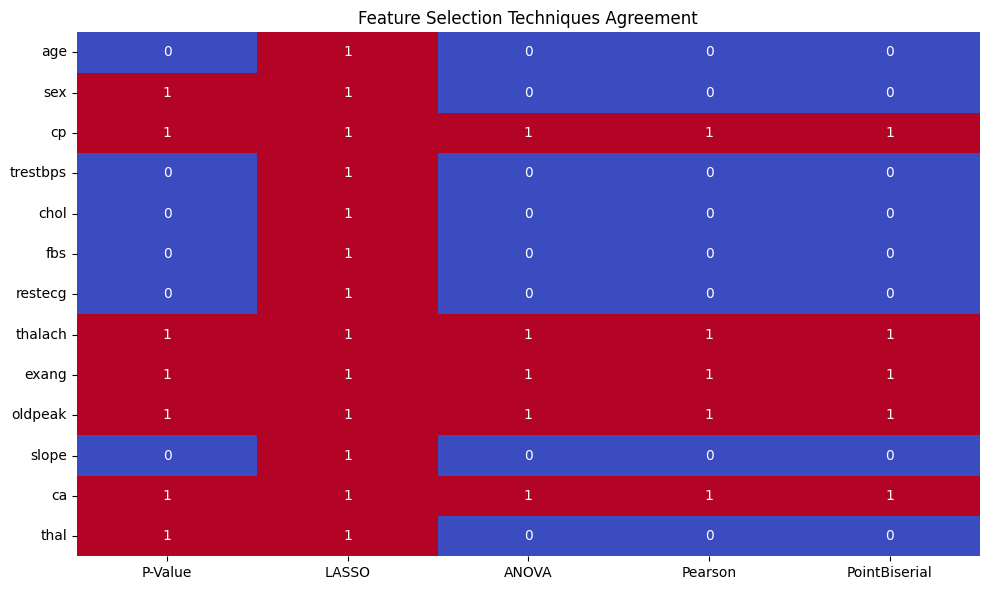

In [4]:
all_methods = pd.DataFrame({
    "P-Value": X.columns.isin(pvalue_selected), # Combine Feature Selection
    "LASSO": X.columns.isin(lasso_selected),
    "ANOVA": X.columns.isin(anova_selected),
    "Pearson": X.columns.isin(corr_selected),
    "PointBiserial": X.columns.isin(pbs_selected),
}, index=X.columns)

print("\nFeature Selection Summary:\n", all_methods)

plt.figure(figsize=(10, 6))
sns.heatmap(all_methods.astype(int), annot=True, cmap="coolwarm", cbar=False)
plt.title("Feature Selection Techniques Agreement")
plt.tight_layout()
plt.show()

# **Models**

In [5]:
X_train_full, X_test_full, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}


def evaluate_model(name, model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    }


results = []

In [7]:
for name, model in models.items():
    res = evaluate_model(name + " (All Features)", model, X_train_full, X_test_full) # Baseline
    results.append(res)

#After Feature Selection define reduced sets

feature_sets = {
    "P-Value": pvalue_selected,
    "LASSO": lasso_selected,
    "ANOVA": anova_selected,
    "Pearson": corr_selected,
    "PointBiserial": pbs_selected
}

for method, selected_features in feature_sets.items():
    X_train_fs = X_train_full[selected_features]
    X_test_fs = X_test_full[selected_features]
    for name, model in models.items():
        res = evaluate_model(name + f" ({method})", model, X_train_fs, X_test_fs)
        results.append(res)


In [8]:
results_df = pd.DataFrame(results)
print("\n📊 Model Performance Comparison:\n")
print(results_df.sort_values(by="Accuracy", ascending=False))


📊 Model Performance Comparison:

                                 Model  Accuracy        F1   ROC_AUC
2                   KNN (All Features)  0.918033  0.920635  0.917565
26                         KNN (LASSO)  0.918033  0.920635  0.917565
20                  KNN (All Features)  0.918033  0.920635  0.917565
8                          KNN (LASSO)  0.918033  0.920635  0.917565
23                       KNN (P-Value)  0.885246  0.888889  0.936422
5                        KNN (P-Value)  0.885246  0.888889  0.936422
1          RandomForest (All Features)  0.868852  0.875000  0.946659
3         LogisticRegression (P-Value)  0.868852  0.875000  0.907328
21        LogisticRegression (P-Value)  0.868852  0.875000  0.907328
15  LogisticRegression (PointBiserial)  0.868852  0.870968  0.885776
9           LogisticRegression (ANOVA)  0.868852  0.870968  0.885776
12        LogisticRegression (Pearson)  0.868852  0.870968  0.885776
30        LogisticRegression (Pearson)  0.868852  0.870968  0.885776


/tmp/ipython-input-9-3420968836.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")


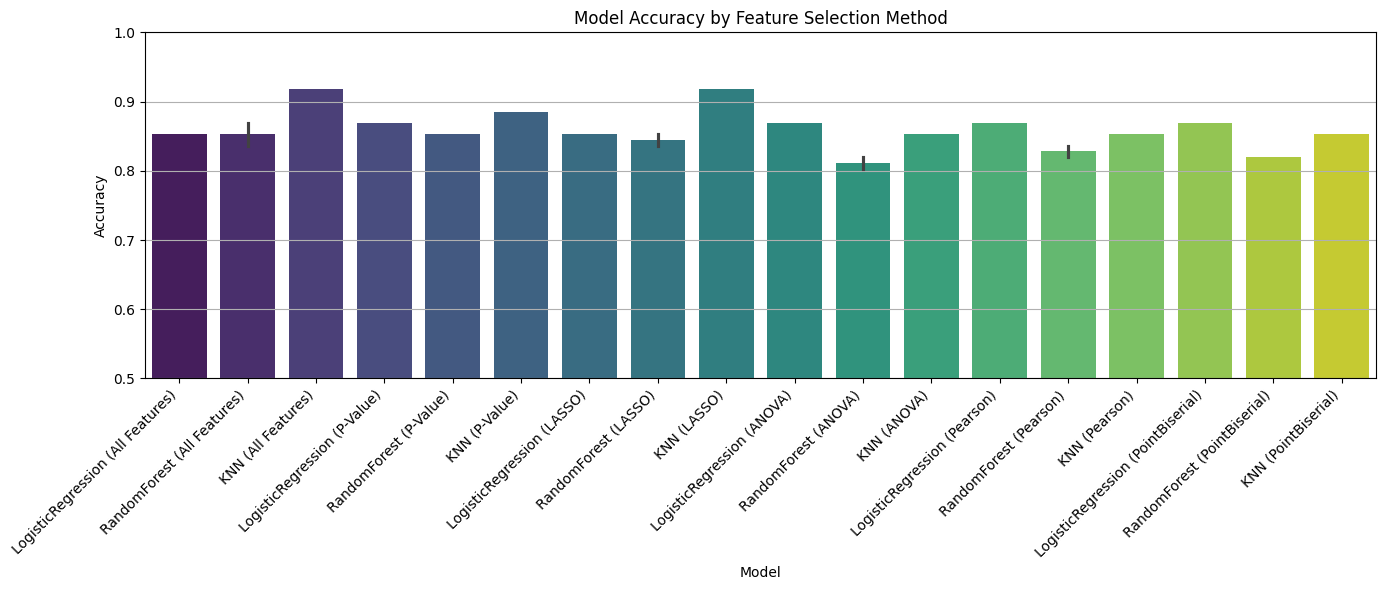

In [9]:
plt.figure(figsize=(14, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis")
plt.title("Model Accuracy by Feature Selection Method")
plt.xticks(rotation=45, ha='right')
plt.ylim(0.5, 1)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

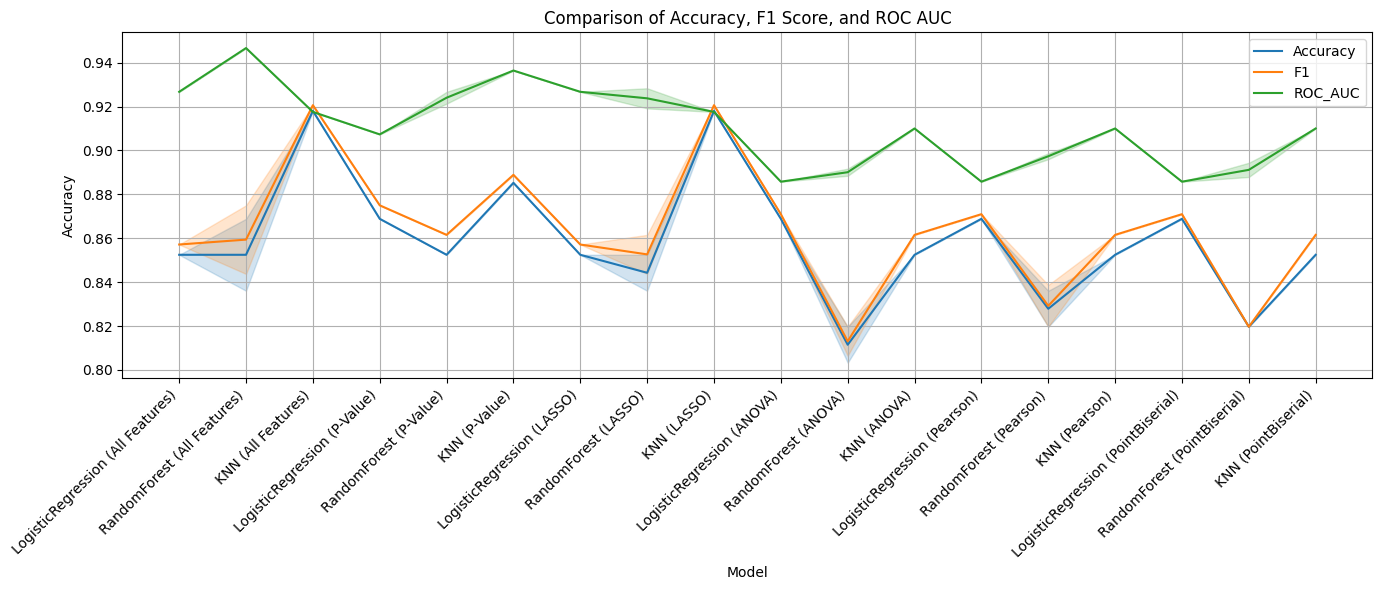

In [10]:
metrics = ['Accuracy', 'F1', 'ROC_AUC']
plt.figure(figsize=(14, 6))
for metric in metrics:
    sns.lineplot(x='Model', y=metric, data=results_df, label=metric)
plt.xticks(rotation=45, ha='right')
plt.title("Comparison of Accuracy, F1 Score, and ROC AUC")
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Pivot table for heatmap
Группируем и усредняем Accuracy а потом Строим сводную таблицу

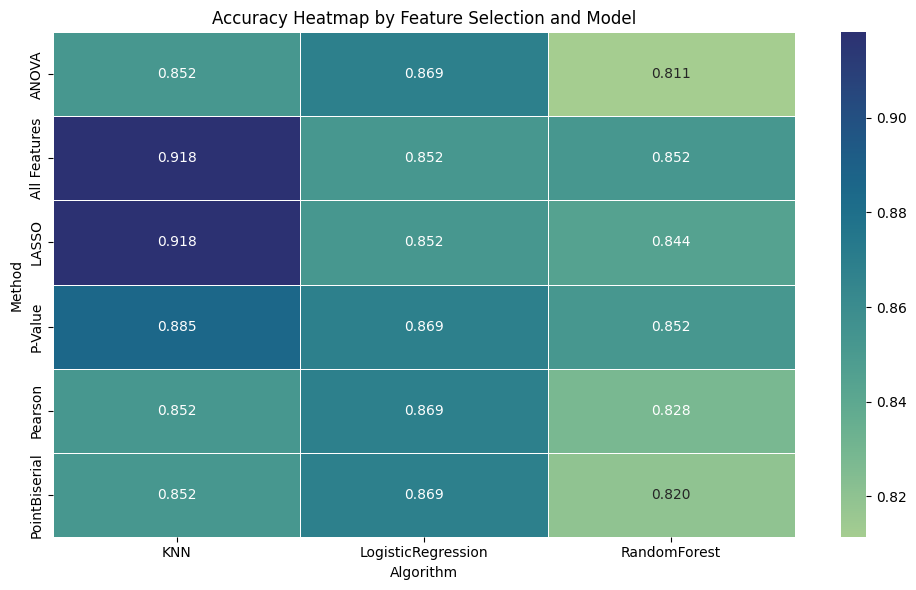

In [23]:
pivot = results_df.copy()
pivot[['Algorithm', 'Method']] = pivot['Model'].str.extract(r'^(.*?) \((.*?)\)$')

pivot_grouped = pivot.groupby(["Method", "Algorithm"])["Accuracy"].mean().reset_index()

pivot_table = pivot_grouped.pivot(index="Method", columns="Algorithm", values="Accuracy")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="crest", linewidths=0.5)
plt.title("Accuracy Heatmap by Feature Selection and Model")
plt.tight_layout()
plt.show()


# **Comparative Analysis**

Разделим на baseline и post-feature-selection

In [17]:
results_df["Type"] = results_df["Model"].apply(lambda x: "Before FS" if "All Features" in x else "After FS")
results_df[['Algorithm', 'Method']] = results_df['Model'].str.extract(r'^(.*?) \((.*?)\)$')

In [20]:
comparison_table = summary_comparison.pivot(index="Algorithm", columns="Type", values=["Accuracy", "F1", "ROC_AUC"])
comparison_table.columns = ['_'.join(col).strip() for col in comparison_table.columns.values]
comparison_table["Accuracy_Diff"] = comparison_table["Accuracy_After FS"] - comparison_table["Accuracy_Before FS"]
comparison_table["F1_Diff"] = comparison_table["F1_After FS"] - comparison_table["F1_Before FS"]
comparison_table["ROC_AUC_Diff"] = comparison_table["ROC_AUC_After FS"] - comparison_table["ROC_AUC_Before FS"]

print("\n📉 Comparative Analysis: Before vs After Feature Selection\n")
print(comparison_table.round(4))


📉 Comparative Analysis: Before vs After Feature Selection

                    Accuracy_After FS  Accuracy_Before FS  F1_After FS  \
Algorithm                                                                
KNN                            0.8721              0.9180       0.8788   
LogisticRegression             0.8656              0.8525       0.8690   
RandomForest                   0.8311              0.8525       0.8352   

                    F1_Before FS  ROC_AUC_After FS  ROC_AUC_Before FS  \
Algorithm                                                               
KNN                       0.9206            0.9168             0.9176   
LogisticRegression        0.8571            0.8983             0.9267   
RandomForest              0.8594            0.9053             0.9467   

                    Accuracy_Diff  F1_Diff  ROC_AUC_Diff  
Algorithm                                                 
KNN                       -0.0459  -0.0418       -0.0008  
LogisticRegression        

/tmp/ipython-input-21-2250373825.py:10: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


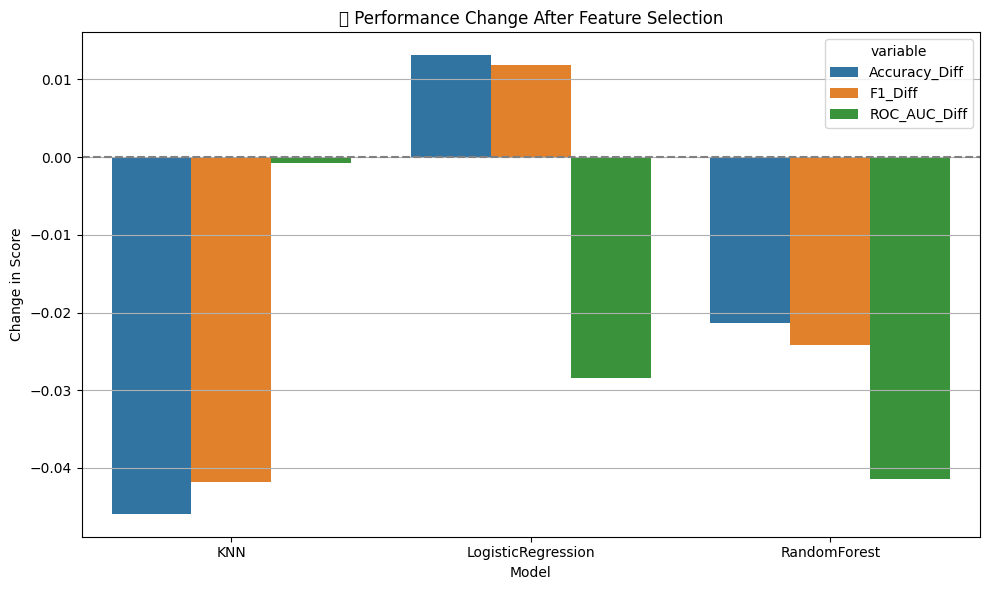

In [21]:
comparison_table_plot = comparison_table[["Accuracy_Diff", "F1_Diff", "ROC_AUC_Diff"]].reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_table_plot.melt(id_vars="Algorithm"), x="Algorithm", y="value", hue="variable")
plt.axhline(0, color='gray', linestyle='--')
plt.title("🎯 Performance Change After Feature Selection")
plt.ylabel("Change in Score")
plt.xlabel("Model")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()